In [13]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib import rc,cm,colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob,os
from scipy.interpolate import interp1d
from datetime import date
from linecache import getline as gl
from pathlib import Path
import calendar
import array as arr
from scipy.interpolate import griddata
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 15}
rc('font', **font)

In [5]:
os.chdir("/scratch/p/peltier/huoyilin/CanadaLakeData/NOAAGLERL")
# Read header
hdr = [gl('g19790101.ct', i) for i in range(1,7)]
values = [float(h.split(" ")[-1].strip()) for h in hdr]
ncols, nrows, xllcorner, yllcorner, cellsize, NODATA_value = values
del hdr, values
# Read latitude/longitude data
lat_gl = np.loadtxt("1024_latgrid.txt")
lon_gl = np.loadtxt("1024_longrid.txt")
dayindex=np.zeros((365*40+10))
Ice_gl=np.zeros((int(ncols),int(nrows)))
year1=1979
for iyear in range (year1-1979,40):
    for file in sorted(glob.glob('g'+str(iyear+1979)+'*.ct')):
        imonth=int(file[5:7])
        iday=int(file[7:9])
        date1 = date(iyear+1979, imonth, iday)
        delta = date1 - date(1979, 1, 1)
        if delta.days>(date(year1,2,24) - date(1979,1,1)).days: #IMS data starts from 2004/2/25
            dayindex[delta.days]=1
            data = np.loadtxt(file, skiprows=7)
            data[data<0]=np.nan
            Ice_gl+=data
nday=np.sum(dayindex)
Ice_gl/=nday
np.savetxt('Ice_GLERL'+str(year1)+'-2018.dat',Ice_gl)
np.savetxt('dayindex_GLERL'+str(year1)+'-2018.dat',dayindex)

In [ ]:
os.chdir("/scratch/p/peltier/huoyilin/CanadaLakeData/IMS/")
q=nc.Dataset('2004/ims2004056_4km_v1.2.nc','r',format='NETCDF4')
IMS_Surface_Values = q.variables['IMS_Surface_Values'][0]# 0: Outside Coverage Area, 1: Open Water 2: Land Without Snow, 3: Sea Ice or Lake Ice 4: Snow Covered Land
Lakemask=IMS_Surface_Values*0;Lakemask[IMS_Surface_Values==1]=1;Lakemask[IMS_Surface_Values==3]=1
ny=len(IMS_Surface_Values);nx=len(IMS_Surface_Values[0])
# Read latitude/longitude data
n = np.fromfile('imslon_4km.bin',dtype=np.float32).reshape(nx,ny)
lon_ims = n.copy().view(np.float32);lon_ims[lon_ims>180]=lon_ims[lon_ims>180]-360;
lon_ims=np.flip(lon_ims, axis=0)
n = np.fromfile('imslat_4km.bin',dtype=np.float32).reshape(nx,ny)
lat_ims = n.copy().view(np.float32) 
lake_list=['Superior','Huron','Michigan','Ontario', 'Erie','GreatBear','GreatSlave','Athabasca','Winnipegosis', 'Winnipeg']
lakenum=len(lake_list)
year1=2004
count=0
for iyear in range(2004,2018):
#     if calendar.isleap(iyear):
#         monthstartday=arr.array('i', [1,32,61,92,122, 153, 183, 214, 245, 275, 306, 336, 367] ) 
#     else:
#         monthstartday=arr.array('i', [1,32,60,91,121, 152, 182, 213, 244, 274, 305, 335, 366])
#     month1=0;
    day1=1
    if iyear==year1: #first year        
        IMS_Surface_Values = np.zeros((nx,ny))
#         month1=2
        day1=56
#     for imonth in range(month1,12):
#         for iday in range(monthstartday[imonth],monthstartday[imonth+1]):
    for iday in range(day1,366+calendar.isleap(iyear)):
            file1 = Path(str(iyear)+'/ims'+str(iyear)+"%03d" % (iday)+'_4km_v1.2.nc')
            file2 = Path(str(iyear)+'/ims'+str(iyear)+"%03d" % (iday)+'_4km_v1.3.nc')
            dayvalue=iday+(date(iyear-1,12,31) - date(1979,1,1)).days
            if dayindex[dayvalue]>0: ###if NOAAGLERL data is available
                if file1.exists():
                    q=nc.Dataset(file1,'r',format='NETCDF4');
                    IMS_Surface_Values += q.variables['IMS_Surface_Values'][0]# 0: Outside Coverage Area, 1: Open Water 2: Land Without Snow, 3: Sea Ice or Lake Ice 4: Snow Covered Land
                    count+=1
                elif file2.exists():
                    q=nc.Dataset(file2,'r',format='NETCDF4');
                    IMS_Surface_Values += q.variables['IMS_Surface_Values'][0]# 0: Outside Coverage Area, 1: Open Water 2: Land Without Snow, 3: Sea Ice or Lake Ice 4: Snow Covered Land
                    count+=1
IMS_Surface_Values=(IMS_Surface_Values/count-1)/2#avg; linear transformation from 1,3 to 0-1
np.savetxt('IMS_Surface_Values_GLERLavailabledate.dat',IMS_Surface_Values) 
q=nc.Dataset(lake_list[0]+'_ims_mask.nc','r',format='NETCDF4')
# ims_lake=q.variables['mask_array'][:]*0
# for lakeid in range(0,5):
#     q=nc.Dataset(lake_list[lakeid]+'_ims_mask.nc','r',format='NETCDF4')
#     ims_lake+=q.variables['mask_array'][:]
# ims_lake*=Lakemask;ims_lake[ims_lake>0]=1


In [11]:
# year1=1979
# Ice_gl=np.loadtxt('/scratch/p/peltier/huoyilin/CanadaLakeData/NOAAGLERL/Ice_GLERL'+str(year1)+'-2018.dat')
# dayindex=np.loadtxt('/scratch/p/peltier/huoyilin/CanadaLakeData/NOAAGLERL/dayindex_GLERL'+str(year1)+'-2018.dat')
#lake_list=['Superior','Huron','Michigan','Ontario', 'Erie']
#nlake=len(lake_list)
#q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[0]+'_mask.nc','r',format='NETCDF4')
#wrf_lake=q.variables['mask_array'][:]
#for lakeid in range(1, nlake):
#    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
#    wrf_lake+=q.variables['mask_array'][:]

model='78g'
q=nc.Dataset('/scratch/p/peltier/huoyilin/mahdinia/wrfconst_d01_RC'+model+'_LAKEMASK_LAKE_DEPTH.nc','r',format='NETCDF4')
wrf_land=q.variables['LAKEMASK'][0]
wrf_lat=q.variables['XLAT'][0]
wrf_lon=q.variables['XLONG'][0]
nlat=len(wrf_lat);nlon=len(wrf_lat[0])
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_daily.nc','r',format='NETCDF4')
LakeIce=q.variables['IceFrac_H0.001']
ntim=len(LakeIce)
LakeIce_daily=np.zeros( (int(ntim/8),nlat,nlon) )
for itim in range (0,ntim-1,8):
        LakeIce_daily[int(itim/8)] = np.mean(LakeIce[itim+1:itim+9],axis=0)
LakeIce=LakeIce_daily
ntim=len(LakeIce)
Ice_tmp=LakeIce[0]*0
for itim in range(0,ntim):
    Ice_tmp+= LakeIce[itim]*dayindex[itim]
Ice_tmp/=nday
Ice_f= 100*griddata((wrf_lon.flatten(),wrf_lat.flatten()), Ice_tmp.flatten(), (lon_gl, lat_gl))-Ice_gl
# Ice_f=Ice_tmp

model='14'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_daily.nc','r',format='NETCDF4')
LakeIce= q.variables['IceFrac_A60']#for DM
ntim=len(LakeIce)
Ice_tmp=LakeIce[0]*0
for itim in range(0,ntim):
    Ice_tmp+= LakeIce[itim]*dayindex[itim]
Ice_tmp/=nday
Ice_d= 100*griddata((wrf_lon.flatten(),wrf_lat.flatten()), Ice_tmp.flatten(), (lon_gl, lat_gl))-Ice_gl
# Ice_d=Ice_tmp

##for GL25
model='13'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_daily.nc','r',format='NETCDF4')
LAKE_ICEFRAC3D = q.variables['LAKE_ICEFRAC3D']
LakeIce=LAKE_ICEFRAC3D[:,0,:,:] #top layer ice
LakeIce[LakeIce < 0] = 0
ntim=len(LakeIce)
Ice_tmp=LakeIce[0]*0
for itim in range(0,ntim):
    Ice_tmp+= LakeIce[itim]*dayindex[itim]
Ice_tmp/=nday
Ice_g= 100*griddata((wrf_lon.flatten(),wrf_lat.flatten()), Ice_tmp.flatten(), (lon_gl, lat_gl))-Ice_gl
# Ice_g=Ice_tmp



In [6]:
model='69'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfout/wrfconst_d01.nc','r',format='NETCDF4')
wrf_land=q.variables['LAKEMASK'][0]
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfout/wrfconst_d01.nc','r',format='NETCDF4')
wrf_lat=q.variables['XLAT'][0]
wrf_lon=q.variables['XLONG'][0]
#nlat=len(wrf_lat);nlon=len(wrf_lat[0])

q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
LakeIce= q.variables['IceFrac_A60']#for DM
Ice_tmp=np.mean(LakeIce,axis=0)
Ice_d=Ice_tmp

##for GL25
model='67'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
LAKE_ICEFRAC3D = q.variables['LAKE_ICEFRAC3D']
LakeIce=LAKE_ICEFRAC3D[:,0,:,:] #top layer ice
LakeIce[LakeIce < 0] = 0
Ice_tmp=np.mean(LakeIce,axis=0)
Ice_g=Ice_tmp

model='76a'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
LakeIce=q.variables['IceFrac_H0.001']
Ice_tmp=np.mean(LakeIce,axis=0)
Ice_f=Ice_tmp

<ipython-input-30-598cb48ecd38>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax1.pcolor(lon_gl, lat_gl, Ice_gl, cmap='gnuplot2_r',vmin=0, vmax=80)
<ipython-input-30-598cb48ecd38>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax1.pcolor(lon_gl, lat_gl, Ice_d, cmap='seismic_r',vmin=v1, vmax=v2)
<ipython-input-30-598cb48ecd38>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eit

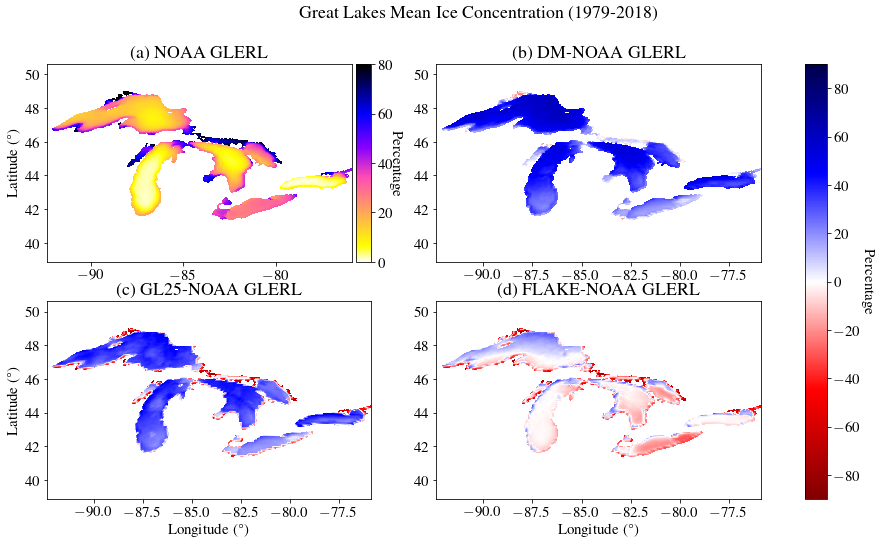

In [30]:
# Ice_gl=np.loadtxt('/scratch/p/peltier/huoyilin/CanadaLakeData/NOAAGLERL/Ice_GLERL2004-2018.dat')
# IMS_Surface_Values=np.loadtxt('/scratch/p/peltier/huoyilin/CanadaLakeData/IMS/IMS_Surface_Values_GLERLavailabledate.dat')
v1=-90;v2=-v1
#hgt_w=q.variables['HGT'][0]
lon1=np.min(lon_gl);lon2=np.max(lon_gl);lat1=np.min(lat_gl);lat2=np.max(lat_gl)
#lon1=-126;lon2=-107;lat1=58;lat2=68
#lon1=-102;lon2=-96;lat1=50;lat2=55
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax1= axes.flat[0];
ax1.title.set_text('(a) NOAA GLERL') 
im=ax1.pcolor(lon_gl, lat_gl, Ice_gl, cmap='gnuplot2_r',vmin=0, vmax=80)
ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Percentage', rotation=-90,labelpad=10)
# ax1= axes.flat[1];
# ax1.title.set_text('(b) IMS') 
# im=ax1.pcolor(lon_ims[1621:2053,2746:3173], lat_ims[1621:2053,2746:3173], IMS_Surface_Values[1621:2053,2746:3173]*100*Lakemask[1621:2053,2746:3173], cmap='gnuplot2_r',vmin=v1, vmax=v2)
# ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
# ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
ax1= axes.flat[1];
ax1.title.set_text('(b) DM-NOAA GLERL')
#im=ax1.pcolor(wrf_lon, wrf_lat, Ice_d*100*wrf_land, cmap='gnuplot2_r',vmin=v1, vmax=v2)
im=ax1.pcolor(lon_gl, lat_gl, Ice_d, cmap='seismic_r',vmin=v1, vmax=v2)
#ax1.contour(wrf_lon, wrf_lat, hgt_w, levels=[500],colors='k')
ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
#ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
ax1= axes.flat[2];
ax1.title.set_text('(c) GL25-NOAA GLERL')
#ax1.pcolor(wrf_lon, wrf_lat, hgt_w, cmap='terrain')
#ax1.pcolor(wrf_lon, wrf_lat, Ice_g*100, cmap='seismic_r',vmin=v1, vmax=v2)
im=ax1.pcolor(lon_gl, lat_gl, Ice_g, cmap='seismic_r',vmin=v1, vmax=v2)
ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
ax1.set_xlabel('Longitude (\N{DEGREE SIGN})')
ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
ax1= axes.flat[3];
ax1.title.set_text('(d) FLAKE-NOAA GLERL')
ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
#im=ax1.pcolor(wrf_lon, wrf_lat, Ice_f*100, cmap='seismic_r',vmin=v1, vmax=v2)
im=ax1.pcolor(lon_gl, lat_gl, Ice_f, cmap='seismic_r',vmin=v1, vmax=v2)
#ax1.contour(wrf_lon, wrf_lat, hgt_w, colors='k')
ax1.set_xlabel('Longitude (\N{DEGREE SIGN})')
#ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
cbar = fig.colorbar(im, ax=axes.ravel().tolist())#, orientation = 'horizontal'
cbar.set_label('Percentage', rotation=-90, labelpad=15)
plt.suptitle('Great Lakes Mean Ice Concentration ('+str(year1)+'-2018)') 
fig.patch.set_facecolor('xkcd:white')
plt.show() 

In [27]:
np.nanmean(Ice_g)

27.828763622586365

In [3]:
year1=2004
os.chdir("/scratch/p/peltier/huoyilin/CanadaLakeData/NOAAGLERL")
# Read header
hdr = [gl('g19790101.ct', i) for i in range(1,7)]
values = [float(h.split(" ")[-1].strip()) for h in hdr]
ncols, nrows, xllcorner, yllcorner, cellsize, NODATA_value = values
del hdr, values
# Read latitude/longitude data
lat_gl = np.loadtxt("1024_latgrid.txt")
lon_gl = np.loadtxt("1024_longrid.txt")
dayindex=np.loadtxt('dayindex_GLERL2004-2018.dat')
nday=np.sum(dayindex)
os.chdir("/scratch/p/peltier/huoyilin/CanadaLakeData/IMS/")
q=nc.Dataset('2004/ims2004056_4km_v1.2.nc','r',format='NETCDF4')
IMS_Surface_Values = q.variables['IMS_Surface_Values'][0]# 0: Outside Coverage Area, 1: Open Water 2: Land Without Snow, 3: Sea Ice or Lake Ice 4: Snow Covered Land
Lakemask=IMS_Surface_Values*0;Lakemask[IMS_Surface_Values==1]=1;Lakemask[IMS_Surface_Values==3]=1
ny=len(IMS_Surface_Values);nx=len(IMS_Surface_Values[0])
# Read latitude/longitude data
n = np.fromfile('imslon_4km.bin',dtype=np.float32).reshape(nx,ny)
lon_ims = n.copy().view(np.float32);lon_ims[lon_ims>180]=lon_ims[lon_ims>180]-360;
lon_ims=np.flip(lon_ims, axis=0)
n = np.fromfile('imslat_4km.bin',dtype=np.float32).reshape(nx,ny)
lat_ims = n.copy().view(np.float32) 

<ipython-input-44-66a9604805cf>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=plt.pcolor(lon_ims[1621:2053,2746:3173], lat_ims[1621:2053,2746:3173], IMS_Surface_Values[1621:2053,2746:3173]*100, cmap='gnuplot2_r',vmin=v1, vmax=v2)


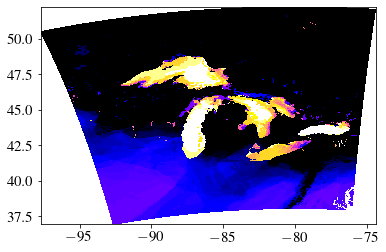

In [44]:
nday=np.sum(dayindex)
np.sum(IMS_Surface_Values*100*Lakemask>0)
lat1
IMS_Surface_Values[IMS_Surface_Values<0]=4
im=plt.pcolor(lon_ims[1621:2053,2746:3173], lat_ims[1621:2053,2746:3173], IMS_Surface_Values[1621:2053,2746:3173]*100, cmap='gnuplot2_r',vmin=v1, vmax=v2)
